# **Cluster Return Prediction with VAR and Evaluation**

In [21]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
from scipy import sparse
from sklearn.cluster import KMeans, SpectralClustering
from statsmodels.tsa.vector_ar.var_model import VAR

# Setup paths (adjust if your notebook is in a different location relative to Main_modules)
try:
    module_path = os.path.abspath(os.path.join(os.getcwd(), '../Main_modules'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    # This import will be replaced by the class defined in this notebook
    # from PyFolioC_classes import ClusterVARForecaster # Placeholder, will use local class
except Exception as e:
    print(f"Error setting up module path: {e}")

warnings.filterwarnings("ignore")

# Attempt to import Signet and install if not found
try:
    from signet.cluster import Cluster
except ImportError:
    print("Signet package not found. Attempting to install from GitHub...")
    try:
        import subprocess
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "git+https://github.com/alan-turing-institute/SigNet.git"]
        )
        from signet.cluster import Cluster
        print("Signet package installed successfully.")
    except Exception as e:
        print(f"Error installing Signet package: {e}")
        print("Please install it manually: pip install git+https://github.com/alan-turing-institute/SigNet.git")
        # sys.exit(1) # Exiting might be too aggressive for a notebook, consider alternatives

class ClusterVARForecaster:
    """
    Performs clustering on asset returns, fits a VAR model to cluster returns,
    forecasts future cluster returns, and calculates forecast errors.
    Uses Gaussian distance to centroid for intra-cluster weighting (for cluster return calculation).
    """
    def __init__(self, n_clusters, cluster_method, var_order, sigma_for_weights=0.01):
        """
        Initializes the ClusterVARForecaster.

        Args:
            n_clusters (int): Number of clusters to form.
            cluster_method (str): Method for clustering assets ('SPONGE', 'signed_laplacian',
                                  'SPONGE_sym', 'Kmeans', 'spectral_clustering').
            var_order (int): Order of the VAR model.
            sigma_for_weights (float): Sigma for Gaussian distance weighting within clusters.
        """
        self.n_clusters = max(1, int(n_clusters))
        self.cluster_method = cluster_method
        self.var_order = max(1, int(var_order))
        self.sigma_for_weights = sigma_for_weights
        self.corr_matrix_ = None
        self.cluster_definitions_ = None # Stores {'Cluster_1': {'tickers': [], 'centroid_ts': pd.Series()}, ...}
        # Attributes to store lookback indices for use in _calculate_weighted_cluster_returns
        self.lookback_start_idx_ = None
        self.lookback_end_idx_ = None


    def _calculate_correlation_matrix(self, asset_returns_lookback_df):
        if asset_returns_lookback_df.empty:
            return pd.DataFrame()
        mean_vals = asset_returns_lookback_df.mean(axis=0)
        std_vals = asset_returns_lookback_df.std(axis=0)
        std_vals[std_vals < 1e-9] = 1.0
        normalized_data = (asset_returns_lookback_df - mean_vals) / std_vals
        return normalized_data.corr(method='pearson').fillna(0)

    def _apply_clustering_algorithm(self, correlation_matrix_df, num_clusters_to_form):
        def _get_signet_data(corr_df):
            pos_corr = corr_df.applymap(lambda x: x if x >= 0 else 0)
            neg_corr = corr_df.applymap(lambda x: abs(x) if x < 0 else 0)
            return (sparse.csc_matrix(pos_corr.values), sparse.csc_matrix(neg_corr.values))

        if correlation_matrix_df.empty:
            return np.array([])
        num_assets = correlation_matrix_df.shape[0]
        effective_n_clusters = min(num_clusters_to_form, num_assets) if num_assets > 0 else 1
        if effective_n_clusters <= 0: return np.array([])

        if self.cluster_method == 'SPONGE':
            signet_data = _get_signet_data(correlation_matrix_df)
            cluster_obj = Cluster(signet_data)
            labels = cluster_obj.SPONGE(effective_n_clusters)
        elif self.cluster_method == 'signed_laplacian':
            signet_data = _get_signet_data(correlation_matrix_df)
            cluster_obj = Cluster(signet_data)
            labels = cluster_obj.spectral_cluster_laplacian(effective_n_clusters)
        elif self.cluster_method == 'SPONGE_sym':
            signet_data = _get_signet_data(correlation_matrix_df)
            cluster_obj = Cluster(signet_data)
            labels = cluster_obj.SPONGE_sym(effective_n_clusters)
        elif self.cluster_method == 'Kmeans':
            data_for_kmeans = correlation_matrix_df.fillna(0)
            kmeans = KMeans(n_clusters=effective_n_clusters, random_state=0, n_init='auto')
            labels = kmeans.fit_predict(data_for_kmeans)
        elif self.cluster_method == 'spectral_clustering':
            affinity_matrix = np.abs(correlation_matrix_df.fillna(0).values)
            affinity_matrix = (affinity_matrix + affinity_matrix.T) / 2
            np.fill_diagonal(affinity_matrix, 1)
            try:
                sc = SpectralClustering(n_clusters=effective_n_clusters, affinity='precomputed',
                                        random_state=0, assign_labels='kmeans')
                labels = sc.fit_predict(affinity_matrix)
            except Exception:
                data_for_kmeans = correlation_matrix_df.fillna(0)
                kmeans = KMeans(n_clusters=effective_n_clusters, random_state=0, n_init='auto')
                labels = kmeans.fit_predict(data_for_kmeans)
        else:
            raise ValueError(f"Unknown clustering method: {self.cluster_method}")

        if not isinstance(labels, np.ndarray) or labels.size == 0:
            if num_assets > 0: return np.zeros(num_assets, dtype=int)
            return np.array([])
        return labels

    def _define_clusters_and_centroids(self, asset_returns_lookback_df):
        self.corr_matrix_ = self._calculate_correlation_matrix(asset_returns_lookback_df)
        num_assets = self.corr_matrix_.shape[0]
        if num_assets == 0:
            self.cluster_definitions_ = {}
            return

        labels = self._apply_clustering_algorithm(self.corr_matrix_, self.n_clusters)
        if labels.size == 0 and num_assets > 0: labels = np.zeros(num_assets, dtype=int)
        elif labels.size == 0 and num_assets == 0:
            self.cluster_definitions_ = {}
            return

        asset_names = list(self.corr_matrix_.columns)
        labeled_assets = pd.DataFrame({'ClusterLabel': labels}, index=asset_names)
        actual_n_clusters = len(np.unique(labels))
        self.n_clusters = actual_n_clusters # Update n_clusters if Signet changed it

        cluster_definitions = {}
        for label_val in np.unique(labels):
            cluster_name = f'Cluster_{label_val + 1}'
            tickers_in_cluster = list(labeled_assets[labeled_assets['ClusterLabel'] == label_val].index)
            if not tickers_in_cluster: continue

            valid_tickers_for_centroid = [t for t in tickers_in_cluster if t in asset_returns_lookback_df.columns]
            if not valid_tickers_for_centroid:
                # Create a zero centroid if no valid tickers or data for them
                centroid_ts = pd.Series(np.zeros(len(asset_returns_lookback_df)), index=asset_returns_lookback_df.index)
            else:
                centroid_ts = asset_returns_lookback_df[valid_tickers_for_centroid].mean(axis=1)

            cluster_definitions[cluster_name] = {'tickers': tickers_in_cluster, 'centroid_ts': centroid_ts}
        self.cluster_definitions_ = cluster_definitions

    def _calculate_weighted_cluster_returns(self, asset_returns_df, period_indices):
        if not self.cluster_definitions_:
            return pd.DataFrame()

        start_idx, end_idx = period_indices # For the CURRENT period to calculate returns for
        if not (0 <= start_idx < end_idx <= len(asset_returns_df)):
            return pd.DataFrame(index=pd.Index([]), columns=list(self.cluster_definitions_.keys()))

        # Data slice for the current period (either lookback or evaluation)
        data_slice_current_period = asset_returns_df.iloc[start_idx:end_idx]
        cluster_returns_dict = {}

        for cluster_name, info in self.cluster_definitions_.items():
            tickers_in_cluster = info['tickers']
            # Centroid was calculated over the lookback period defined by self.lookback_start_idx_ and self.lookback_end_idx_
            centroid_lookback_ts = info['centroid_ts']

            asset_gaussian_weights = {}
            total_gaussian_weight_sum = 0.0

            # 1. Calculate Gaussian weights for assets based on distance to LOOKBACK centroid
            for ticker in tickers_in_cluster:
                if ticker in asset_returns_df.columns:
                    # Get asset returns from the original lookback period for distance calculation
                    asset_returns_during_lookback = asset_returns_df[ticker].iloc[self.lookback_start_idx_:self.lookback_end_idx_]

                    if len(asset_returns_during_lookback) == len(centroid_lookback_ts):
                        squared_distance = np.sum((centroid_lookback_ts.values - asset_returns_during_lookback.values)**2)
                        weight = np.exp(-squared_distance / (2 * (self.sigma_for_weights**2)))
                        asset_gaussian_weights[ticker] = weight
                        total_gaussian_weight_sum += weight
                    else:
                        asset_gaussian_weights[ticker] = 0.0 # Mismatch, assign zero weight
                else:
                    asset_gaussian_weights[ticker] = 0.0 # Ticker not in main df

            # 2. Normalize weights and calculate weighted returns for the CURRENT data_slice_current_period
            current_cluster_period_returns = pd.Series(0.0, index=data_slice_current_period.index)
            if total_gaussian_weight_sum > 1e-9:
                for ticker, unnormalized_weight in asset_gaussian_weights.items():
                    if ticker in data_slice_current_period.columns: # Check if ticker has data in current slice
                        normalized_weight = unnormalized_weight / total_gaussian_weight_sum
                        current_cluster_period_returns += data_slice_current_period[ticker] * normalized_weight
            elif tickers_in_cluster: # Fallback to equal weight for assets present in the current slice
                valid_tickers_in_current_slice = [t for t in tickers_in_cluster if t in data_slice_current_period.columns]
                if valid_tickers_in_current_slice:
                    equal_weight = 1.0 / len(valid_tickers_in_current_slice)
                    for ticker_in_slice in valid_tickers_in_current_slice:
                        current_cluster_period_returns += data_slice_current_period[ticker_in_slice] * equal_weight

            cluster_returns_dict[cluster_name] = current_cluster_period_returns.values

        if not cluster_returns_dict: # Should not happen if self.cluster_definitions_ is not empty
            return pd.DataFrame(index=data_slice_current_period.index)
        return pd.DataFrame(cluster_returns_dict, index=data_slice_current_period.index)


    def _fit_var_and_forecast(self, lookback_cluster_returns_df, forecast_horizon):
        data_for_var = lookback_cluster_returns_df.astype(float).dropna(axis=1, how='all')
        if data_for_var.empty or data_for_var.shape[0] <= self.var_order or data_for_var.shape[1] == 0:
            return pd.DataFrame(columns=lookback_cluster_returns_df.columns if not lookback_cluster_returns_df.empty else ["dummy_var_col"])

        try:
            model = VAR(data_for_var)
            # Ensure var_order (used as maxlags) is less than num_observations/num_series
            # A common heuristic for maxlags in fit() is related to T (num_obs)
            # Here, we use self.var_order as the specific lag order for fit.
            # If self.var_order causes issues (e.g., too large for data), VAR.fit() might fail.
            # Statsmodels VAR.fit() takes `maxlags` and `ic` or a specific lag order.
            # If we pass `self.var_order` directly as `maxlags` and `ic=None`, it uses that lag.

            # Ensure var_order is not too large for the number of observations
            # This check is simplified; more complex conditions exist for VAR stability.
            effective_var_order = self.var_order
            if self.var_order >= data_for_var.shape[0] - data_for_var.shape[1]*self.var_order : # A loose check
                 effective_var_order = max(1, (data_for_var.shape[0] // (data_for_var.shape[1] +1)) -1 ) # Fallback heuristic


            results = model.fit(effective_var_order)
            lag_order_used = results.k_ar
            forecast_input = data_for_var.values[-lag_order_used:]
            forecast_array = results.forecast(y=forecast_input, steps=forecast_horizon)
        except Exception as e:
            # print(f"VAR model fitting/forecasting failed: {e}. Returning empty forecast.")
            return pd.DataFrame(columns=data_for_var.columns)

        forecast_index = pd.RangeIndex(start=0, stop=forecast_horizon, step=1)
        if not data_for_var.empty and hasattr(data_for_var.index, 'freq') and data_for_var.index.freq is not None:
            try:
                forecast_index = pd.date_range(start=data_for_var.index[-1] + data_for_var.index.freq,
                                            periods=forecast_horizon, freq=data_for_var.index.freq)
            except Exception: pass

        forecast_df = pd.DataFrame(forecast_array, columns=data_for_var.columns, index=forecast_index)
        return forecast_df.reindex(columns=lookback_cluster_returns_df.columns, fill_value=0.0)

    def process_step(self, asset_returns_df, lookback_indices, eval_len):
        # Store lookback indices for use in _calculate_weighted_cluster_returns
        self.lookback_start_idx_, self.lookback_end_idx_ = lookback_indices

        lookback_asset_returns = asset_returns_df.iloc[self.lookback_start_idx_:self.lookback_end_idx_]
        self._define_clusters_and_centroids(lookback_asset_returns)

        if not self.cluster_definitions_:
            empty_df = pd.DataFrame()
            return empty_df, empty_df

        lookback_cluster_returns = self._calculate_weighted_cluster_returns(asset_returns_df, lookback_indices)
        if lookback_cluster_returns.empty or lookback_cluster_returns.isnull().all().all():
            empty_df = pd.DataFrame(columns=list(self.cluster_definitions_.keys()) if self.cluster_definitions_ else [])
            return empty_df, empty_df.copy()

        forecasted_returns = self._fit_var_and_forecast(lookback_cluster_returns, eval_len)

        eval_start_idx = self.lookback_end_idx_
        eval_end_idx = self.lookback_end_idx_ + eval_len
        eval_end_idx = min(eval_end_idx, len(asset_returns_df))
        # actual_eval_len = eval_end_idx - eval_start_idx # Not directly used below, but good for context

        if eval_start_idx >= eval_end_idx: # No evaluation period possible
            true_eval_returns = pd.DataFrame(columns=forecasted_returns.columns if not forecasted_returns.empty else (list(self.cluster_definitions_.keys()) if self.cluster_definitions_ else []))
            return forecasted_returns.head(0), true_eval_returns


        true_eval_returns = self._calculate_weighted_cluster_returns(asset_returns_df,
                                                                         (eval_start_idx, eval_end_idx))

        # Align forecast index with true evaluation data index for easier comparison later
        if not forecasted_returns.empty and not true_eval_returns.empty:
            if len(forecasted_returns) == len(true_eval_returns):
                 forecasted_returns.index = true_eval_returns.index
            elif len(forecasted_returns) > len(true_eval_returns): # Forecast is longer
                  forecasted_returns = forecasted_returns.iloc[:len(true_eval_returns)]
                  forecasted_returns.index = true_eval_returns.index
            # If forecast is shorter, lengths will mismatch, error calculation needs to handle.

        # Ensure columns match between forecast and true returns
        if not forecasted_returns.empty and not true_eval_returns.empty:
            common_cols = forecasted_returns.columns.intersection(true_eval_returns.columns)
            forecasted_returns = forecasted_returns[common_cols]
            true_eval_returns = true_eval_returns[common_cols]
        elif forecasted_returns.empty and not true_eval_returns.empty:
            forecasted_returns = pd.DataFrame(index=true_eval_returns.index, columns=true_eval_returns.columns).fillna(0)
        elif not forecasted_returns.empty and true_eval_returns.empty:
            true_eval_returns = pd.DataFrame(index=forecasted_returns.index, columns=forecasted_returns.columns).fillna(0)

        return forecasted_returns, true_eval_returns

def calculate_forecast_errors(forecast_df, actual_df, metric='mse'):
    if forecast_df.empty or actual_df.empty:
        return pd.Series(dtype=float)

    common_cols = forecast_df.columns.intersection(actual_df.columns)
    if common_cols.empty:
        return pd.Series(dtype=float)

    f_aligned = forecast_df[common_cols].copy() # Use .copy() to avoid SettingWithCopyWarning if indices are reset
    a_aligned = actual_df[common_cols].copy()

    if len(f_aligned) != len(a_aligned):
        # Try to align by truncating the longer one if indices are not aligned
        min_len = min(len(f_aligned), len(a_aligned))
        f_aligned = f_aligned.iloc[:min_len]
        a_aligned = a_aligned.iloc[:min_len]
        # print(f"Warning: Length mismatch. Truncated to {min_len} for error calculation.")

    # Reset index for direct subtraction if they are not already identical
    if not f_aligned.index.equals(a_aligned.index):
        f_aligned.reset_index(drop=True, inplace=True)
        a_aligned.reset_index(drop=True, inplace=True)

    errors = f_aligned - a_aligned

    if metric.lower() == 'mse': scores = (errors ** 2).mean()
    elif metric.lower() == 'mae': scores = errors.abs().mean()
    elif metric.lower() == 'rmse': scores = np.sqrt((errors ** 2).mean())
    else: raise ValueError(f"Unknown error metric: {metric}")
    return scores

def run_sliding_window_var_evaluation(
    asset_returns_df, initial_lookback_len, eval_len, n_clusters,
    cluster_method, var_order, sigma_intra_cluster, num_windows, error_metric='mse',
    store_sample_forecasts=True # New parameter
):
    all_window_errors = []
    # To store sample data for plotting
    sample_forecast_data = None
    sample_actual_data = None
    sample_window_idx = None

    forecaster = ClusterVARForecaster(
        n_clusters=n_clusters, cluster_method=cluster_method,
        var_order=var_order, sigma_for_weights=sigma_intra_cluster
    )

    for i in range(num_windows):
        lb_start = i * eval_len
        lb_end = lb_start + initial_lookback_len

        if lb_end + eval_len > len(asset_returns_df):
            break

        print(f"Processing window {i+1}/{num_windows}...")
        forecast_df, actual_df = forecaster.process_step(
            asset_returns_df=asset_returns_df,
            lookback_indices=(lb_start, lb_end),
            eval_len=eval_len
        )

        if forecast_df.empty and actual_df.empty:
            continue

        if forecast_df.empty or actual_df.empty:
            continue

        common_cols = forecast_df.columns.intersection(actual_df.columns)
        if common_cols.empty:
            continue

        forecast_df_aligned = forecast_df[common_cols].copy() # Ensure we work with copies for alignment
        actual_df_aligned = actual_df[common_cols].copy()

        if len(forecast_df_aligned) != len(actual_df_aligned):
            min_len = min(len(forecast_df_aligned), len(actual_df_aligned))
            if min_len == 0:
                continue
            forecast_df_aligned = forecast_df_aligned.iloc[:min_len]
            actual_df_aligned = actual_df_aligned.iloc[:min_len]
            # Align indices if they became misaligned due to truncation
            actual_df_aligned.index = forecast_df_aligned.index


        window_errors = calculate_forecast_errors(forecast_df_aligned, actual_df_aligned, metric=error_metric)

        if not window_errors.empty:
            print(f"  Window {i+1} {error_metric_config.upper()}: {window_errors.mean():.6f} (avg across clusters)")
            all_window_errors.append(window_errors)

            # Store data for the first successfully processed window with non-empty aligned data
            if store_sample_forecasts and sample_forecast_data is None and not forecast_df_aligned.empty and not actual_df_aligned.empty:
                sample_forecast_data = forecast_df_aligned.copy()
                sample_actual_data = actual_df_aligned.copy()
                sample_window_idx = i
                print(f"    Stored sample forecast/actual data from window {i+1}")


    if store_sample_forecasts:
        return all_window_errors, sample_forecast_data, sample_actual_data, sample_window_idx
    else:
        return all_window_errors

## 1. Clean the Data

In [22]:
# Adjust path as per your file location
file_path = r'C:\Users\james\ICAIF_25\Data\OPCL_20000103_20201231.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the path.")
    # df = pd.DataFrame() # Create empty df to avoid further errors if needed, or sys.exit()
    # For notebook, better to let it proceed and user can fix path

if not df.empty:
    df.set_index('ticker', inplace=True)
    df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%Y-%m-%d') # Standard date format
    df_cleaned = df.dropna().transpose()
    df_cleaned.index = pd.to_datetime(df_cleaned.index)
    print(df_cleaned.iloc[0:5,0:5]) # Display first 5 rows/cols
else:
    print("DataFrame is empty, cannot proceed with data cleaning.")
    df_cleaned = pd.DataFrame() # Ensure df_cleaned exists

ticker            AA       ABM       ABT       ADI       ADM
2000-01-03 -0.013042 -0.009188 -0.007117 -0.036071  0.000000
2000-01-04  0.010043  0.012346 -0.012786 -0.044261  0.005277
2000-01-05  0.047628 -0.006192  0.011111  0.014493 -0.015915
2000-01-06 -0.011713  0.000000  0.032553 -0.027719  0.010695
2000-01-07 -0.016118  0.003091  0.028573  0.033654  0.005249


In [23]:
df_cleaned.shape

(5279, 663)

Using existing df_cleaned with shape: (5279, 663)
DataFrame has 663 assets. Plotting a subset for clarity/performance.


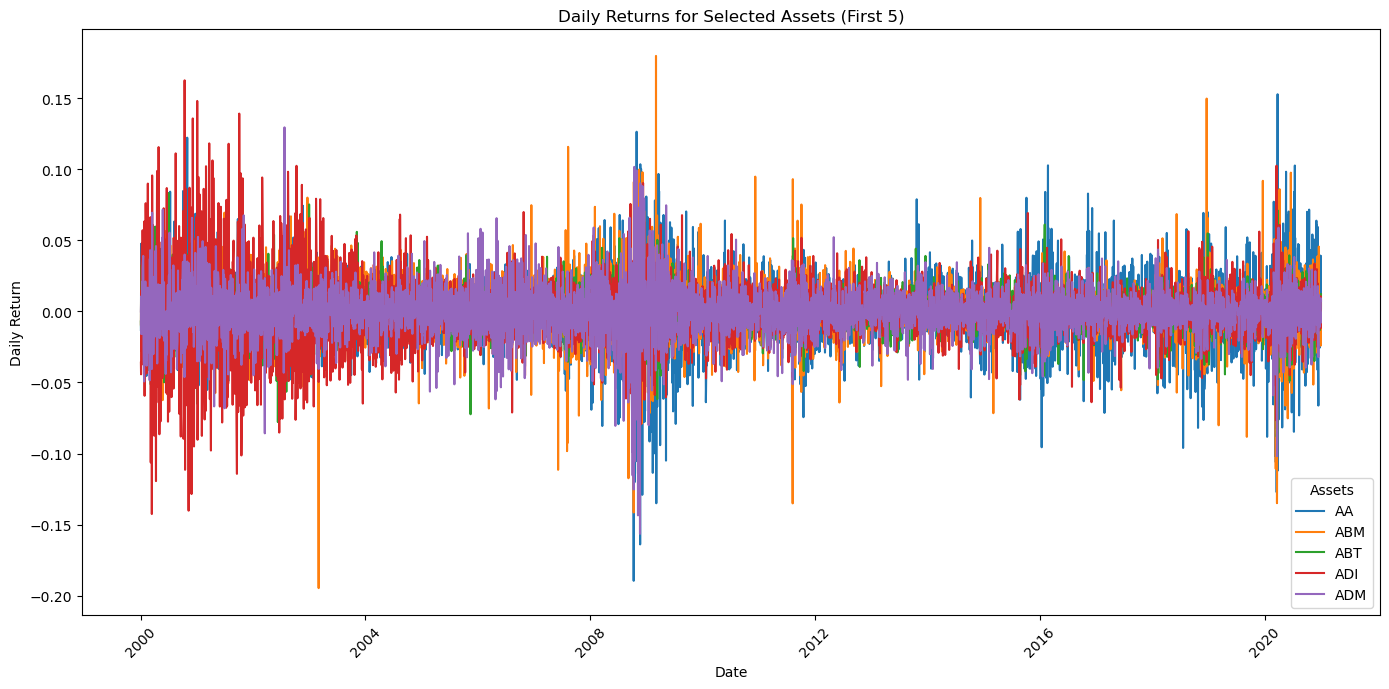

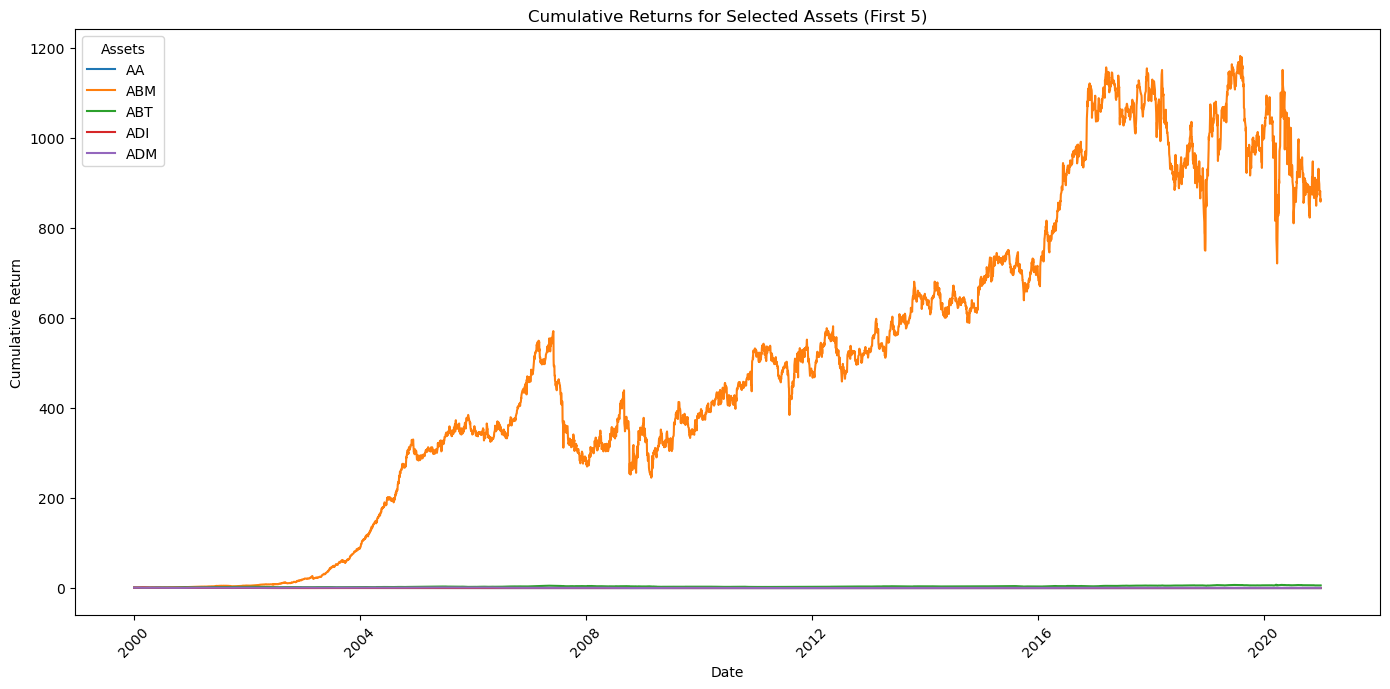

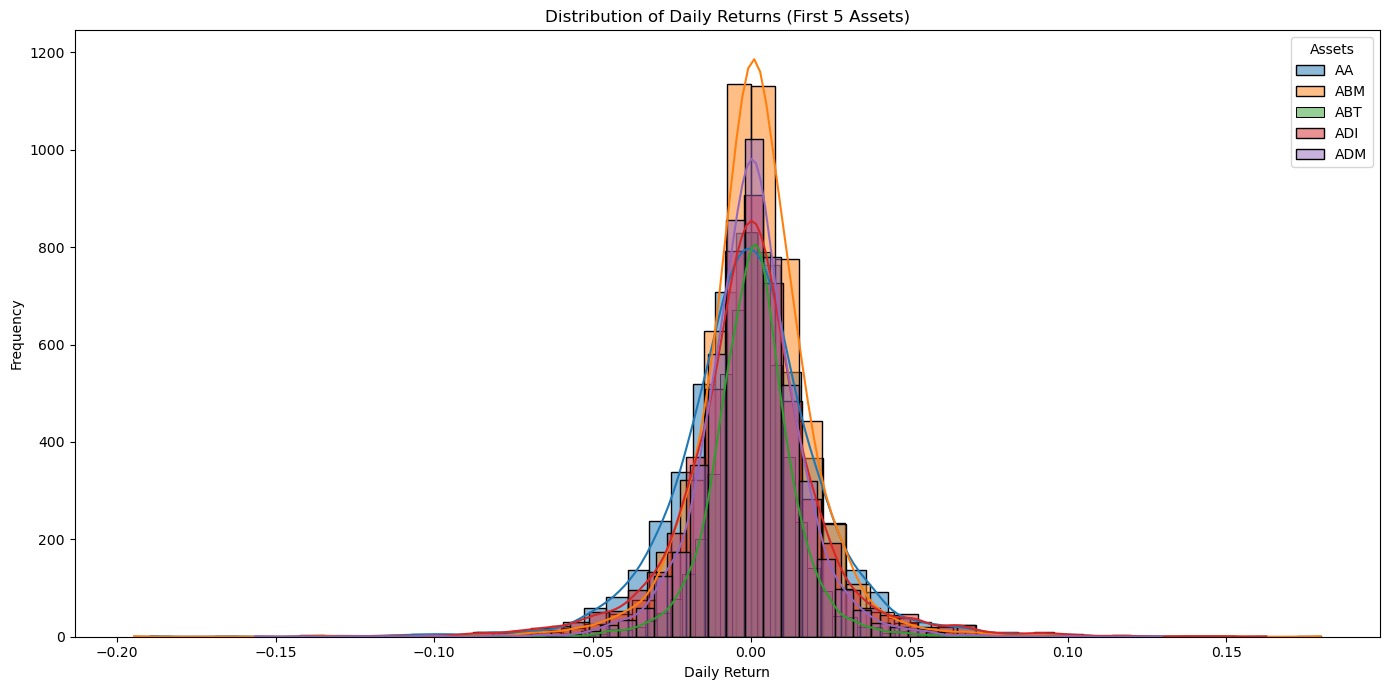

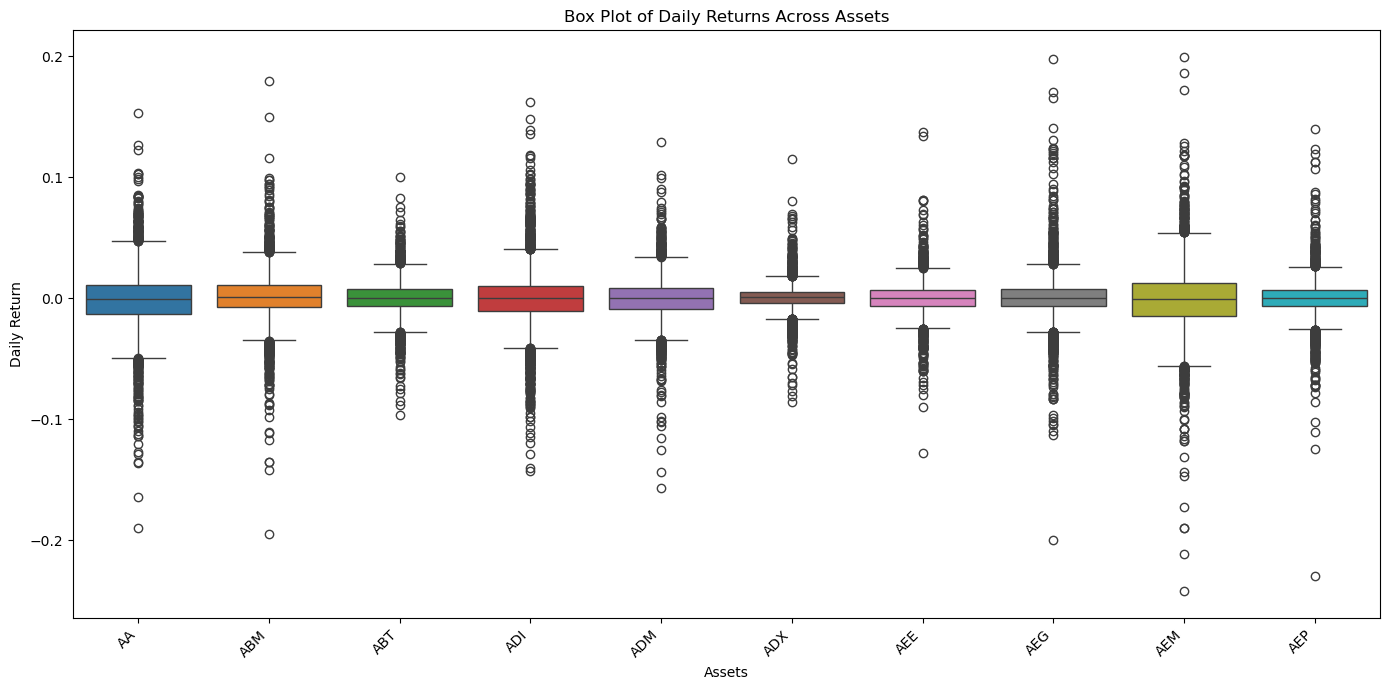

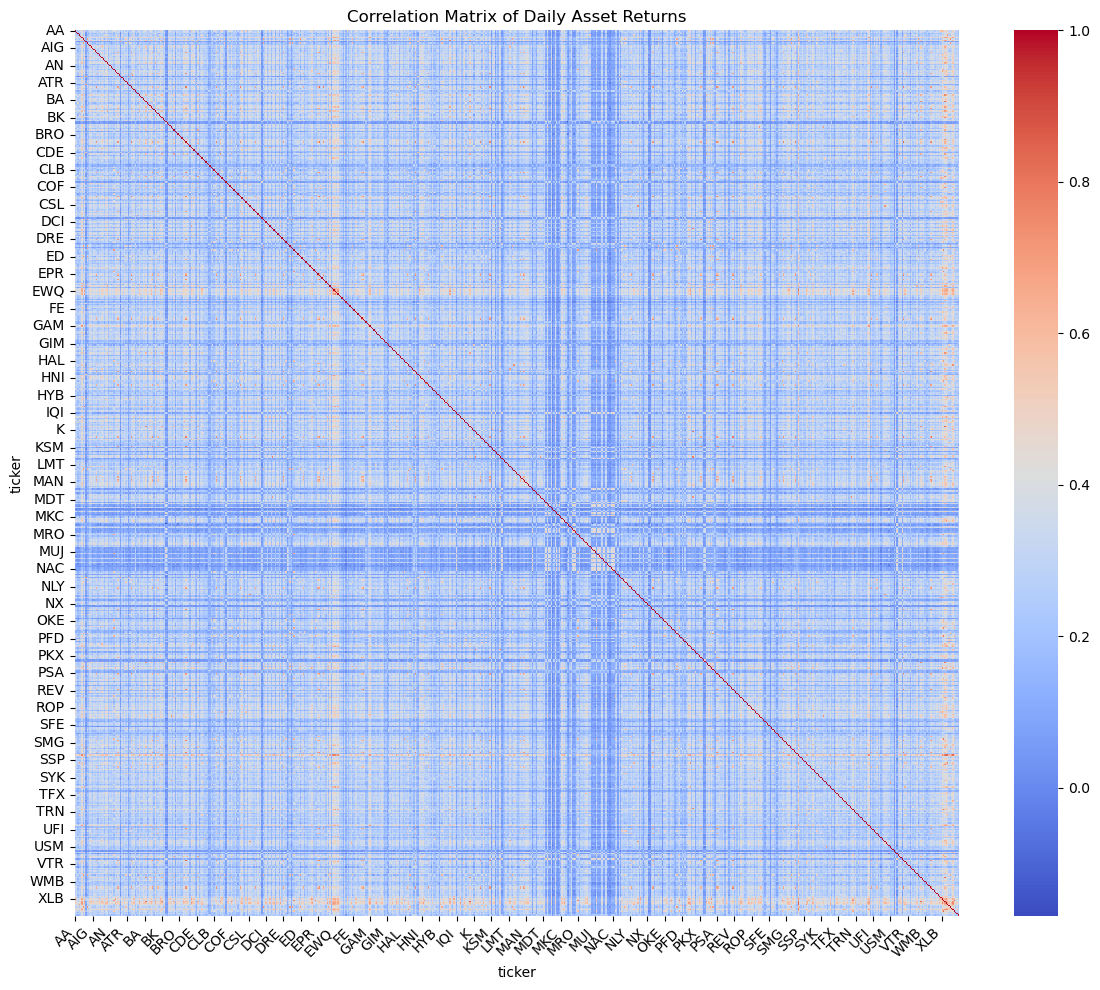

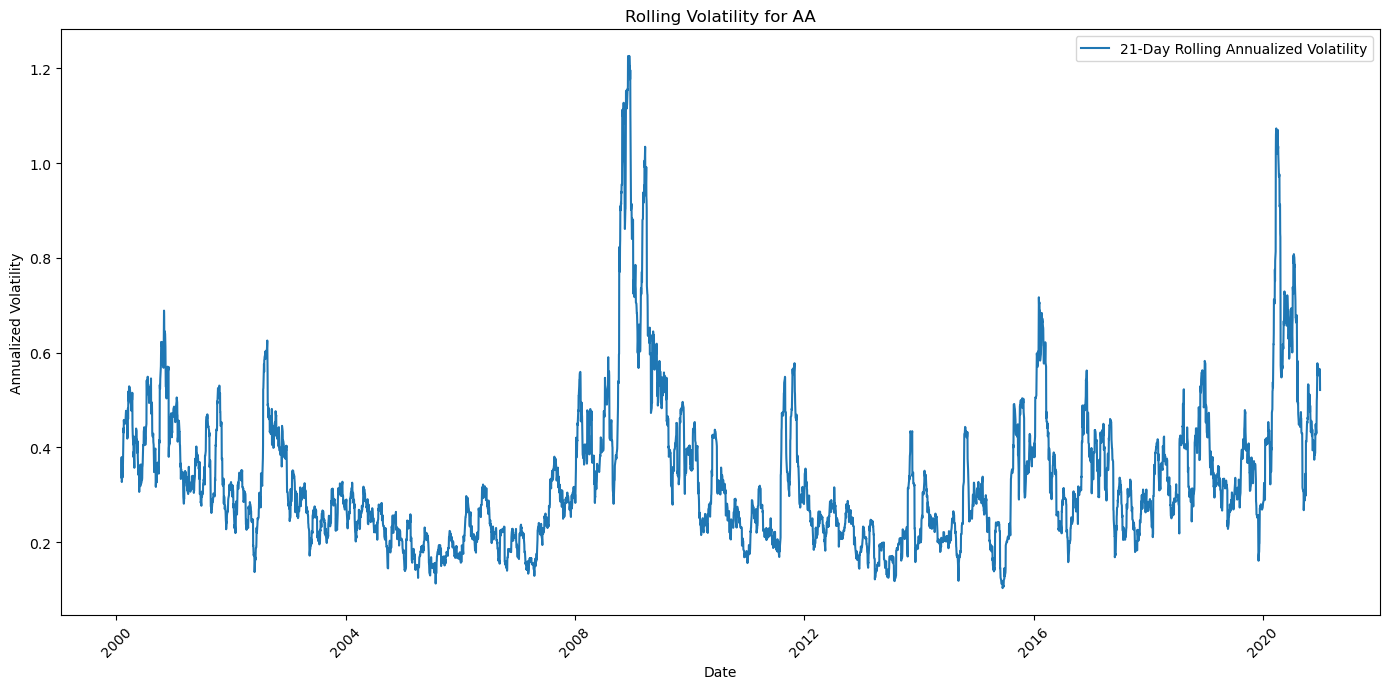

In [24]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf # For autocorrelation plots

# Assuming df_cleaned is your cleaned DataFrame from the previous steps
# (rows are dates, columns are asset tickers, values are returns)

# --- (Your data loading and cleaning code would be here) ---
# For demonstration, let's re-create a similar df_cleaned structure
if 'df_cleaned' not in locals() or df_cleaned.empty: # Check if df_cleaned exists and is not empty
    print("df_cleaned not found or is empty. Creating dummy data for plotting demonstration.")
    dummy_dates = pd.date_range(start='2020-01-01', periods=252*2, freq='B') # Approx 2 years
    dummy_tickers = [f'Asset_{i+1}' for i in range(20)]
    # Generate returns directly
    df_cleaned = pd.DataFrame(np.random.randn(len(dummy_dates), len(dummy_tickers)) * 0.01,
                                index=dummy_dates, columns=dummy_tickers)
    df_cleaned.iloc[0] = 0 # Set first row to 0 if needed for some calculations, or remove if it's an artifact
else:
    print(f"Using existing df_cleaned with shape: {df_cleaned.shape}")

# Ensure df_cleaned is not excessively large for some plots
if df_cleaned.shape[1] > 50: # More than 50 assets
    print(f"DataFrame has {df_cleaned.shape[1]} assets. Plotting a subset for clarity/performance.")
    df_to_plot = df_cleaned.iloc[:, :10].copy() # Plot first 10 assets, use .copy()
elif df_cleaned.empty:
    print("df_cleaned is empty. Cannot generate plots.")
    df_to_plot = pd.DataFrame()
else:
    df_to_plot = df_cleaned.copy()


if not df_to_plot.empty:
    # --- Plot 1: Time Series of Returns for a Few Selected Assets ---
    plt.figure(figsize=(14, 7))
    num_assets_to_plot_ts = min(5, df_to_plot.shape[1])
    for i in range(num_assets_to_plot_ts):
        sns.lineplot(data=df_to_plot.iloc[:, i], label=df_to_plot.columns[i])
    plt.title(f'Daily Returns for Selected Assets (First {num_assets_to_plot_ts})')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend(title='Assets')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Cumulative Returns for a Few Selected Assets ---
    cumulative_returns_df = (1 + df_to_plot).cumprod() - 1
    plt.figure(figsize=(14, 7))
    for i in range(num_assets_to_plot_ts):
        sns.lineplot(data=cumulative_returns_df.iloc[:, i], label=df_to_plot.columns[i])
    plt.title(f'Cumulative Returns for Selected Assets (First {num_assets_to_plot_ts})')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend(title='Assets')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Distribution of Returns for a Few Selected Assets (Histogram/KDE) ---
    plt.figure(figsize=(14, 7))
    for i in range(num_assets_to_plot_ts):
        sns.histplot(df_to_plot.iloc[:, i], kde=True, label=df_to_plot.columns[i], alpha=0.5, bins=50)
    plt.title(f'Distribution of Daily Returns (First {num_assets_to_plot_ts} Assets)')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend(title='Assets')
    plt.tight_layout()
    plt.show()

    # --- Plot 4: Box Plot of Returns Across All (Plotted) Assets ---
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_to_plot)
    plt.title('Box Plot of Daily Returns Across Assets')
    plt.xlabel('Assets')
    plt.ylabel('Daily Return')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # --- Plot 5: Correlation Heatmap of Asset Returns ---
    correlation_matrix_to_plot = df_cleaned.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix_to_plot, cmap='coolwarm')
    plt.title('Correlation Matrix of Daily Asset Returns')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Plot 6: Rolling Volatility for a Selected Asset ---
    if df_to_plot.shape[1] > 0:
        selected_asset_for_vol = df_to_plot.columns[0]
        rolling_window = 21 # Approx 1 month of trading days
        rolling_volatility = df_to_plot[selected_asset_for_vol].rolling(window=rolling_window).std() * np.sqrt(252) # Annualized
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=rolling_volatility, label=f'{rolling_window}-Day Rolling Annualized Volatility')
        plt.title(f'Rolling Volatility for {selected_asset_for_vol}')
        plt.xlabel('Date')
        plt.ylabel('Annualized Volatility')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## 2. Run the code

Once the run is completed, you will have a list of error scores for each window.

In [25]:
##################################################################### PARAMETERS #####################################################################
historical_data = df_cleaned
initial_lookback_len = 252  # Approx 1 year of trading days
evaluation_len = 21       # Approx 1 month for forecasting/evaluation
num_clusters_config = 7
cluster_method_config = 'SPONGE_sym' # 'Kmeans', 'spectral_clustering', 'SPONGE', 'signed_laplacian', 'SPONGE_sym'
var_order_config = 20
sigma_config = 0.01 # Sigma for Gaussian weighting within clusters
num_windows_config = 50  # Number of sliding windows
error_metric_config = 'rmse' # 'mse', 'mae', 'rmse'
####################################################################################################################################################

# Make sure df_cleaned (historical_data) is defined
if 'df_cleaned' in locals() and not df_cleaned.empty:
    historical_data = df_cleaned
    # Call the modified function
    results = run_sliding_window_var_evaluation(
        asset_returns_df=historical_data,
        initial_lookback_len=initial_lookback_len,
        eval_len=evaluation_len,
        n_clusters=num_clusters_config,
        cluster_method=cluster_method_config,
        var_order=var_order_config,
        sigma_intra_cluster=sigma_config,
        num_windows=num_windows_config,
        error_metric=error_metric_config,
        store_sample_forecasts=True # Ensure this is True
    )

    if len(results) == 4: # Check if we got the sample data back
        list_of_error_series, sample_forecast, sample_actual, stored_window_idx = results
    else: # Fallback if store_sample_forecasts was False or something unexpected
        list_of_error_series = results
        sample_forecast, sample_actual, stored_window_idx = None, None, None


    if list_of_error_series:
        all_errors_df = pd.concat(list_of_error_series, axis=1).T
        all_errors_df.index.name = "Window_ID"
        # ... (rest of your error summary printing)
    else:
        print("\nNo error results generated from the sliding window evaluation.")
        all_errors_df = pd.DataFrame() # Ensure it exists for plotting checks
else:
    print("Historical data is empty. Skipping VAR evaluation.")
    all_errors_df = pd.DataFrame()
    sample_forecast, sample_actual, stored_window_idx = None, None, None

Processing window 1/50...
  Window 1 RMSE: 0.016521 (avg across clusters)
    Stored sample forecast/actual data from window 1
Processing window 2/50...
  Window 2 RMSE: 0.011261 (avg across clusters)
Processing window 3/50...
  Window 3 RMSE: 0.015081 (avg across clusters)
Processing window 4/50...
  Window 4 RMSE: 0.011999 (avg across clusters)
Processing window 5/50...
  Window 5 RMSE: 0.011031 (avg across clusters)
Processing window 6/50...
  Window 6 RMSE: 0.011324 (avg across clusters)
Processing window 7/50...
  Window 7 RMSE: 0.011345 (avg across clusters)
Processing window 8/50...
  Window 8 RMSE: 0.008693 (avg across clusters)
Processing window 9/50...
  Window 9 RMSE: 0.015549 (avg across clusters)
Processing window 10/50...
  Window 10 RMSE: 0.020786 (avg across clusters)
Processing window 11/50...
  Window 11 RMSE: 0.012987 (avg across clusters)
Processing window 12/50...
  Window 12 RMSE: 0.011335 (avg across clusters)
Processing window 13/50...
  Window 13 RMSE: 0.014162

## 3. Visualization of Results (Example)

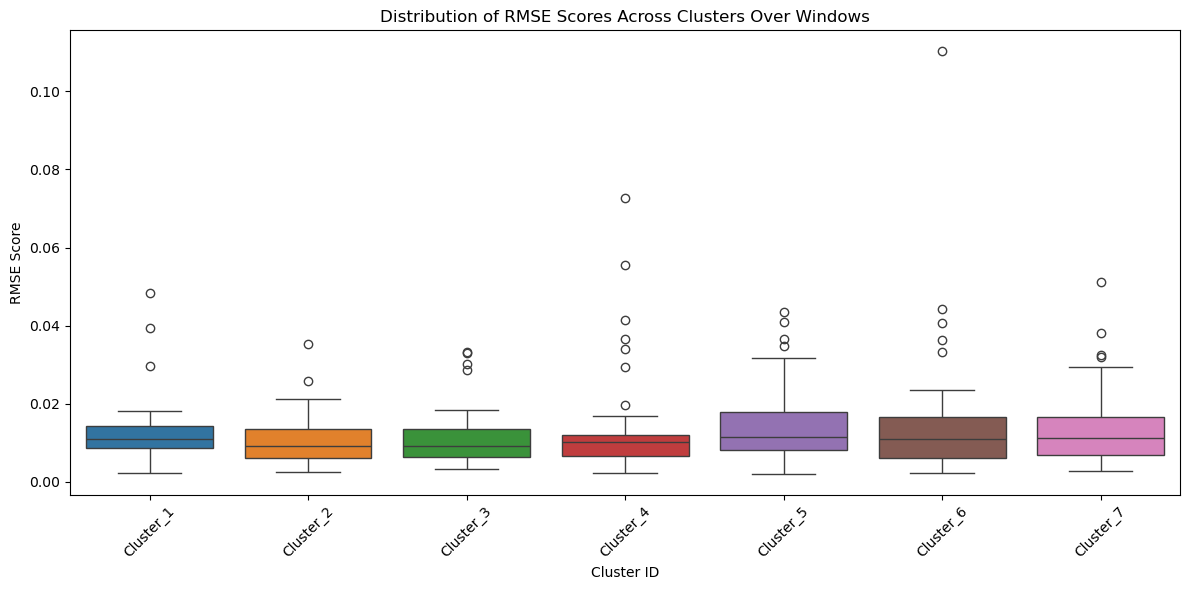

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- (Your existing error plotting code from the question) ---
if 'all_errors_df' in locals() and not all_errors_df.empty:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=all_errors_df)
    plt.title(f'Distribution of {error_metric_config.upper()} Scores Across Clusters Over Windows')
    plt.xlabel('Cluster ID')
    plt.ylabel(f'{error_metric_config.upper()} Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    all_errors_df.mean(axis=1).plot(kind='line', marker='o')
    plt.title(f'Average {error_metric_config.upper()} Score Across Clusters Per Window')
    plt.xlabel('Window ID')
    plt.ylabel(f'Average {error_metric_config.upper()} Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No error data to plot.")

# --- New: Plotting Predictions vs. Actuals for the Sampled Window ---
if 'sample_forecast' in locals() and sample_forecast is not None and \
   'sample_actual' in locals() and sample_actual is not None and \
   'stored_window_idx' in locals() and stored_window_idx is not None:

    print(f"\n--- Plotting Predictions vs. Actuals for Sample Window {stored_window_idx + 1} ---")

    # Determine the number of clusters to plot (e.g., first few or all if not too many)
    num_clusters_to_plot = min(3, sample_forecast.shape[1]) # Plot up to 3 clusters

    if num_clusters_to_plot == 0:
        print("No cluster data available in the sample to plot.")
    else:
        for i in range(num_clusters_to_plot):
            cluster_name = sample_forecast.columns[i]

            plt.figure(figsize=(14, 7))

            # Plot actual values
            sns.lineplot(data=sample_actual[cluster_name], label=f'Actual - {cluster_name}', marker='o', linestyle='-')

            # Plot forecasted values
            sns.lineplot(data=sample_forecast[cluster_name], label=f'Forecast - {cluster_name}', marker='x', linestyle='--')

            plt.title(f'Prediction vs. Actual Cluster Returns for {cluster_name} (Window {stored_window_idx + 1})')
            plt.xlabel('Forecast Step (or Date if index is DatetimeIndex)')
            plt.ylabel('Cluster Return')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # --- Optional: Scatter plot of Predictions vs. Actuals for a cluster ---
        # This can help see the correlation more directly
        if num_clusters_to_plot > 0:
            cluster_to_scatter = sample_forecast.columns[0] # Pick the first plotted cluster
            plt.figure(figsize=(8, 8))
            sns.scatterplot(x=sample_actual[cluster_to_scatter], y=sample_forecast[cluster_to_scatter])
            # Add a y=x line for reference
            min_val = min(sample_actual[cluster_to_scatter].min(), sample_forecast[cluster_to_scatter].min())
            max_val = max(sample_actual[cluster_to_scatter].max(), sample_forecast[cluster_to_scatter].max())
            plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Forecast (y=x)')
            plt.title(f'Scatter Plot: Forecast vs. Actual for {cluster_to_scatter} (Window {stored_window_idx + 1})')
            plt.xlabel(f'Actual Returns - {cluster_to_scatter}')
            plt.ylabel(f'Forecasted Returns - {cluster_to_scatter}')
            plt.legend()
            plt.grid(True)
            plt.axis('equal') # Ensure x and y axes have the same scale
            plt.tight_layout()
            plt.show()

else:
    print("\nNo sample forecast/actual data available to plot predictions vs. actuals.")